In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
import seaborn as sns
from PIL import Image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from google.colab import drive
from sklearn.metrics import confusion_matrix
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Direktori CSV
TRAIN_CSV_PATH_DIR = "/content/drive/MyDrive/TPA_AI/train/_classes.csv"
TEST_CSV_PATH_DIR = "/content/drive/MyDrive/TPA_AI/test/_classes.csv"
VALID_CSV_PATH_DIR = "/content/drive/MyDrive/TPA_AI/valid/_classes.csv"
TRAIN_IMAGE_PATH_DIR = "/content/drive/MyDrive/TPA_AI/train/"
TEST_IMAGE_PATH_DIR = "/content/drive/MyDrive/TPA_AI/test/"
VALID_IMAGE_PATH_DIR = "/content/drive/MyDrive/TPA_AI/valid/"

In [ ]:
# Membaca file CSV
train_dataset = pd.read_csv(TRAIN_CSV_PATH_DIR)
test_dataset = pd.read_csv(TEST_CSV_PATH_DIR)
valid_dataset = pd.read_csv(VALID_CSV_PATH_DIR)

In [ ]:
# Memberikan nama kolum
train_dataset.columns = ["filename", "Brazil", "Canada", "Finland", "Japan", "United-Kingdom", "United_States", "Unlabeled"]

# Filter ambil yang ada labelnya saja alias unlabeled = 1
train_dataset = train_dataset.loc[train_dataset['Unlabeled'] != 1]

# Ambil semua nama file-nya
train_file_name = train_dataset["filename"].to_list()

# Buang kolom yang unlabel
train_dataset = train_dataset.drop("Unlabeled", axis=1)

# Remove indexnya
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
# Memberikan nama kolum
valid_dataset.columns = ["filename", "Brazil", "Canada", "Finland", "Japan", "United-Kingdom", "United_States", "Unlabeled"]

# Filter ambil yang ada labelnya saja alias unlabeled = 1
valid_dataset = valid_dataset.loc[valid_dataset['Unlabeled'] != 1]

# Ambil semua nama file-nya
valid_file_name = valid_dataset["filename"].to_list()

# Buang kolom unlabel
valid_dataset = valid_dataset.drop("Unlabeled", axis=1)

# Remove indexnya
valid_dataset = valid_dataset.reset_index(drop=True)

In [ ]:
# Memberikan nama kolum
test_dataset.columns = ["filename", "Brazil", "Canada", "Finland", "Japan", "United-Kingdom", "United_States", "Unlabeled"]

# Filter ambil yang ada labelnya alias unlabeled = 1
test_dataset = test_dataset.loc[test_dataset['Unlabeled'] != 1]

# Ambil semua nama file-nya
test_file_name = test_dataset["filename"].to_list()

# Buang kolom unlabel
test_dataset = test_dataset.drop("Unlabeled", axis=1)

# Remove indexnya
test_dataset = test_dataset.reset_index(drop=True)

In [ ]:
# Function untuk mendapatkan images beserta labelnya
def get_images_and_labels(image_path, file_names, df):
    images = []
    labels = []
    for idx, file_name in enumerate(file_names):
        if os.path.exists(os.path.join(image_path, file_name)):
            image = Image.open(os.path.join(image_path, file_name))
            image = image.resize((227, 227))
            image = np.array(image)
            images.append(image)
            labels.append([
                df["Brazil"][idx],
                df["Canada"][idx],
                df["Finland"][idx],
                df["Japan"][idx],
                df["United-Kingdom"][idx],
                df["United_States"][idx],
            ])

    return images, labels

In [ ]:
image_train, label_train = get_images_and_labels(TRAIN_IMAGE_PATH_DIR, train_file_name, train_dataset)
image_valid, label_valid = get_images_and_labels(VALID_IMAGE_PATH_DIR, valid_file_name, valid_dataset)
image_test, label_test = get_images_and_labels(TEST_IMAGE_PATH_DIR, test_file_name, test_dataset)

In [ ]:
# Simpan ke dictionary
data_dictionary = {
    "image_train": image_train,
    "label_train": label_train,
    "image_valid": image_valid,
    "label_valid": label_valid,
    "image_test": image_test,
    "label_test": label_test
}

# Simpan dictionary ke npy
np.save("/content/drive/MyDrive/TPA_AI/data_dictionary_v2.npy", data_dictionary)

In [4]:
# Load ulang dari file .npy
data_dictionary = np.load("/content/drive/MyDrive/TPA_AI/data_dictionary_v2.npy", allow_pickle=True).item()

# Assign ulang nilai variabelnya dari hasil file .npy
image_train = data_dictionary["image_train"]
label_train = data_dictionary["label_train"]
image_valid = data_dictionary["image_valid"]
label_valid = data_dictionary["label_valid"]
image_test = data_dictionary["image_test"]
label_test = data_dictionary["label_test"]

In [5]:
# Function untuk preprocess data
def preprocess_data(image, label):
    image = np.array(image)
    image = image.astype(np.float32)
    image = image / 255.0
    label = np.array(label)

    return image, label

In [6]:
(image_train, label_train) = preprocess_data(image_train, label_train)
(image_valid, label_valid) = preprocess_data(image_valid, label_valid)
(image_test, label_test) = preprocess_data(image_test, label_test)

In [7]:
# Membuat Alexnet Model
def AlexNet_model():
    model = Sequential()

    model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding="valid", activation="relu", input_shape=(227, 227, 3)))
    model.add(layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(2048, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation="softmax"))

    opt = Adam(learning_rate=0.0001)
    model.compile(loss=binary_crossentropy, optimizer=opt, metrics=["accuracy"])

    return model

In [8]:
# Membuat instance dari modelnya beserta summary-nya
model = AlexNet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [11]:
# Load model dari .h5 dan menampilkan summary-nya
MODEL_PATH = "/content/drive/MyDrive/TPA_AI/alexnetmodel_v2.h5"
model = load_model(MODEL_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [9]:
# Function untuk train model
def train_model(model, image_train, label_train, image_valid, label_valid, epochs, batch_size):
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    it_train = datagen.flow(image_train, label_train, batch_size=batch_size)

    path_cp = os.getcwd() + "/" + "weights_.hdf5"
    checkpoint = ModelCheckpoint(path_cp, monitor="loss", save_best_only=True, mode="auto")
    steps = image_train.shape[0] // batch_size

    history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(image_valid, label_valid), verbose=1, callbacks=checkpoint)

    _, acc = model.evaluate(image_valid, label_valid, verbose=1)
    print(f"%.3f" % (acc * 100.0))

    return history, acc

In [ ]:
train_history, acc = train_model(model, image_train, label_train, image_valid, label_valid, epochs=5, batch_size=64)

In [15]:
# Save model
model.save("/content/drive/MyDrive/TPA_AI/alexnetmodel_v2.h5")

In [12]:
# Mendapatkan label hasil prediksi
label_test_predictions = []
for i in np.arange(len(image_test)):
  image = image_test[i]
  image = image.reshape(1, 227, 227, 3)
  label_test_prediction = model.predict(image)
  label_test_predictions.append(label_test_prediction)

label_test_predictions = np.asarray(label_test_predictions)

1/1 [==============================] - 0s 62ms/step


Text(95.72222222222221, 0.5, 'True classes')

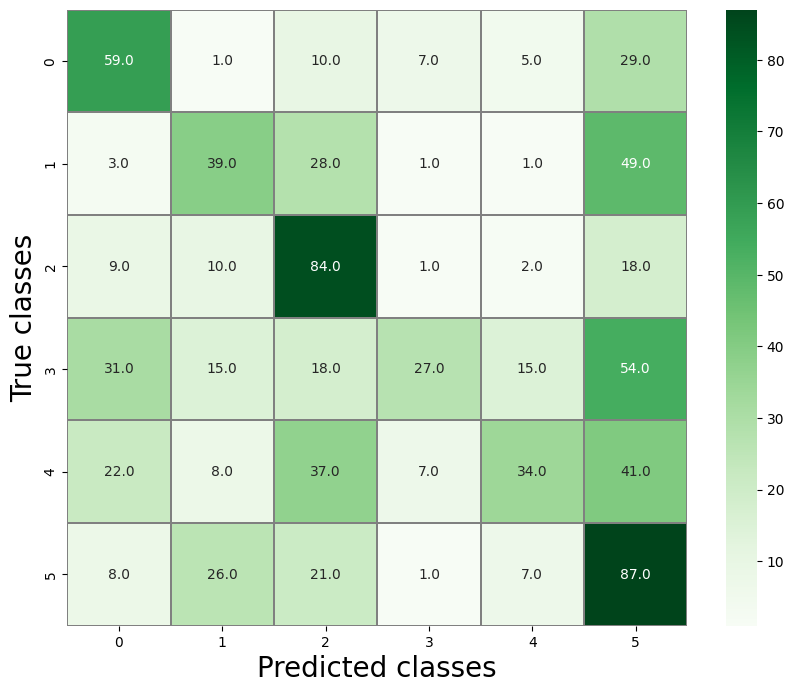

In [13]:
# Evaluasi model menggunakan confusion matrix dan divisualisasi menggunakan heatmap
test_label = [np.argmax(vect) for vect in label_test]
test_label_predictions = [np.argmax(vect) for vect in label_test_predictions]

conf_mat = confusion_matrix(test_label, test_label_predictions)

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, linewidths=0.1, cmap="Greens", linecolor="gray",
            fmt=".1f", annot=True)
plt.xlabel("Predicted classes", fontsize=20)
plt.ylabel("True classes", fontsize=20)